# CSCE 421 :: Machine Learning :: Texas A&M University :: Fall 2021

# Programming Assignment 5 (PA 5) + Competition
**Name:**  Ayad Masud
**UIN:**  733009045

# Convolutional Neural Networks

In this assignment, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**. 
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary. 
- Once you've filled out your solutions, submit the notebook on Canvas following the instructions [here](https://people.engr.tamu.edu/guni/csce421/assignments.html).
- Do **NOT** forget to type in your name and UIN at the beginning of the notebook.

## Data Preparation

In [2]:
# Importing the libraries
import os
import torch
import torchvision
from torchvision.utils import make_grid

import numpy as np

In this assignment, we will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [3]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize

In [4]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(),
    Normalize((0.5,), (0.5,))
    ])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

100%|██████████| 26421880/26421880 [00:02<00:00, 13118544.47it/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 223151.55it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3664399.48it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 2898681.30it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



**NOTE:** You may add more operations to `Compose` if you're performing data augmentation.

## Data Exploration

Let's take a look at the classes in our dataset.

In [5]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [6]:
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: {} ({})'.format(dataset.classes[label], label))
    plt.imshow(img.squeeze(), cmap='Greys_r')
    plt.axis(False)

Label: Dress (3)


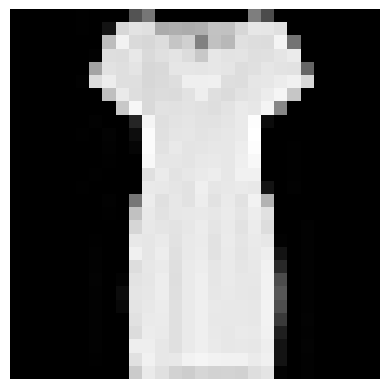

In [7]:
show_example(*dataset[20])

Label: Sneaker (7)


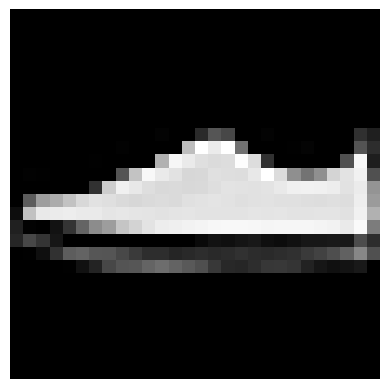

In [8]:
show_example(*dataset[20000])

## Question 1 (10 points)

## Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset.  

**Choose a suitable fraction for your validation set and experiment with the seed. Remember that the better your validation set, the higher the chances that your model would do well on the test set.**

In [9]:
def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [10]:
val_frac = 0.2  # Use 20% of data for validation
rand_seed = 42  # Standard random seed that works well for reproducibility

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("#samples in training set: {}".format(len(train_indices)))
print("#samples in validation set: {}".format(len(val_indices)))


#samples in training set: 48000
#samples in validation set: 12000


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide. 

**Set the `batch_size` depending on the hardware resource (GPU/CPU RAM) you are using for the assignment.**

In [11]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [14]:
# Set the batch size based on available hardware resources
batch_size = 64  # Standard batch size that works well for most hardware setups


In [15]:
# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

Plot images in a sample batch of data.

In [16]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, 8).permute(1, 2, 0), cmap='Greys_r')
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


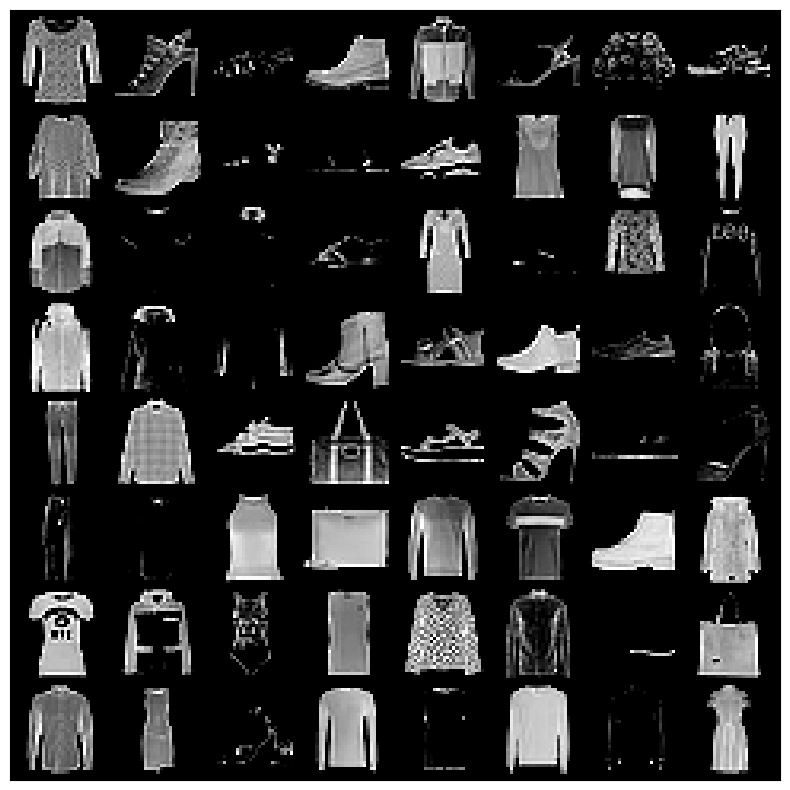

In [17]:
show_batch(train_dl)

## Question 2 (40 points)

## Building the Model

**Create your model by defining the network architecture in the `ImageClassifierNet` class.**  
**NOTE:** The number of parameters in your network must be $\leq$ 100,000.

In [19]:
# Import the libraries
import torch.nn as nn
import torch.nn.functional as F

# Install torchinfo if not already installed
%pip install torchinfo -q

from torchinfo import summary

Note: you may need to restart the kernel to use updated packages.


In [27]:
class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=1):
        super(ImageClassifierNet, self).__init__()
        
        # First convolutional block - reduced filters
        self.conv1 = nn.Conv2d(n_channels, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Second convolutional block - reduced filters
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Fully connected layers - further reduced size
        # After 2 max-pooling layers, the image size is reduced to 7x7
        self.fc1 = nn.Linear(32 * 7 * 7, 50)  # Reduced from 64 to 50
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(50, 10)  # 10 classes in Fashion MNIST
        
    def forward(self, X):
        # First block
        X = self.pool1(F.relu(self.bn1(self.conv1(X))))
        
        # Second block
        X = self.pool2(F.relu(self.bn2(self.conv2(X))))
        
        # Flatten
        X = X.view(X.size(0), -1)
        
        # Fully connected layers
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = self.fc2(X)
        
        return X


In [28]:
model = ImageClassifierNet()

The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [29]:
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 28, 28]          160
├─BatchNorm2d: 1-2                       [64, 16, 28, 28]          32
├─MaxPool2d: 1-3                         [64, 16, 14, 14]          --
├─Conv2d: 1-4                            [64, 32, 14, 14]          4,640
├─BatchNorm2d: 1-5                       [64, 32, 14, 14]          64
├─MaxPool2d: 1-6                         [64, 32, 7, 7]            --
├─Linear: 1-7                            [64, 50]                  78,450
├─Dropout: 1-8                           [64, 50]                  --
├─Linear: 1-9                            [64, 10]                  510
Total params: 83,856
Trainable params: 83,856
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 71.29
Input size (MB): 0.20
Forward/backward pass size (MB): 19.30
Params size (MB): 0.34
Estimated Total Size 

## Enable training on a GPU

**NOTE:** This section is necessary if you're training your model on a GPU.

In [30]:
def get_default_device():
    """Use GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [31]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

to_device(model, device)

ImageClassifierNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=50, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## Question 3 (40 points)

## Train the model

**Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on the validation set.**

In [32]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.
    
    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate
    
    Returns:
        The trained model. 
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    # Initialize the optimizer
    optimizer = opt_fn(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_dl):
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track loss and accuracy
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Print progress
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}/{n_epochs}, Batch: {batch_idx}/{len(train_dl)}, Loss: {loss.item():.4f}')
        
        # Calculate average training metrics for the epoch
        avg_train_loss = train_loss / len(train_dl)
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation phase (if validation data is provided)
        if len(val_dl) > 0:
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for images, labels in val_dl:
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()
            
            # Calculate average validation metrics
            avg_val_loss = val_loss / len(val_dl)
            val_accuracy = correct / total
            val_losses.append(avg_val_loss)
            val_accuracies.append(val_accuracy)
            
            print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
        else:
            print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}')
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies

**Set the maximum number of training epochs, the loss function, the optimizer, and the learning rate.**

In [33]:
import torch.optim as optim

# Standard values for training the model
num_epochs = 10  # Max number of training epochs
loss_fn = nn.CrossEntropyLoss()  # Standard loss function for classification tasks
opt_fn = optim.Adam  # Adam optimizer typically works well for CNNs
lr = 0.001  # Standard learning rate for Adam optimizer

In [34]:
history = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)
model, train_losses, val_losses, train_accuracies, val_accuracies = history

Epoch: 1/10, Batch: 0/750, Loss: 2.3764
Epoch: 1/10, Batch: 100/750, Loss: 0.7478
Epoch: 1/10, Batch: 200/750, Loss: 0.6516
Epoch: 1/10, Batch: 300/750, Loss: 0.8996
Epoch: 1/10, Batch: 400/750, Loss: 0.5218
Epoch: 1/10, Batch: 500/750, Loss: 0.6532
Epoch: 1/10, Batch: 600/750, Loss: 0.4972
Epoch: 1/10, Batch: 700/750, Loss: 0.3668
Epoch 1/10, Train Loss: 0.7305, Train Acc: 0.7277, Val Loss: 0.3747, Val Acc: 0.8645
Epoch: 2/10, Batch: 0/750, Loss: 0.6157
Epoch: 2/10, Batch: 100/750, Loss: 0.5253
Epoch: 2/10, Batch: 200/750, Loss: 0.4360
Epoch: 2/10, Batch: 300/750, Loss: 0.4420
Epoch: 2/10, Batch: 400/750, Loss: 0.4793
Epoch: 2/10, Batch: 500/750, Loss: 0.5572
Epoch: 2/10, Batch: 600/750, Loss: 0.6899
Epoch: 2/10, Batch: 700/750, Loss: 0.5185
Epoch 2/10, Train Loss: 0.5365, Train Acc: 0.7947, Val Loss: 0.3252, Val Acc: 0.8817
Epoch: 3/10, Batch: 0/750, Loss: 0.4632
Epoch: 3/10, Batch: 100/750, Loss: 0.4898
Epoch: 3/10, Batch: 200/750, Loss: 0.5532
Epoch: 3/10, Batch: 300/750, Loss: 0.4

## Plot loss and accuracy

In [35]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

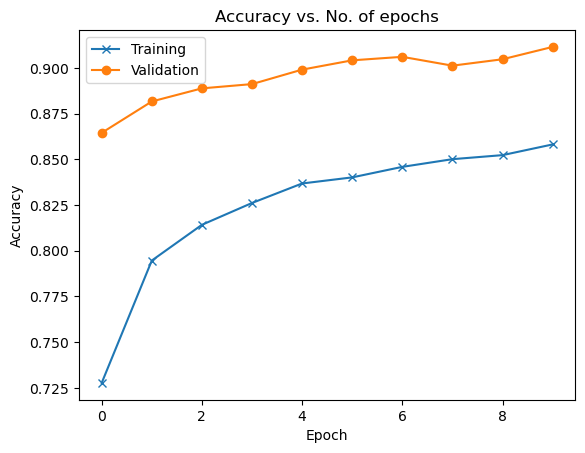

In [36]:
plot_accuracy(train_accuracies, val_accuracies)

In [37]:
def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

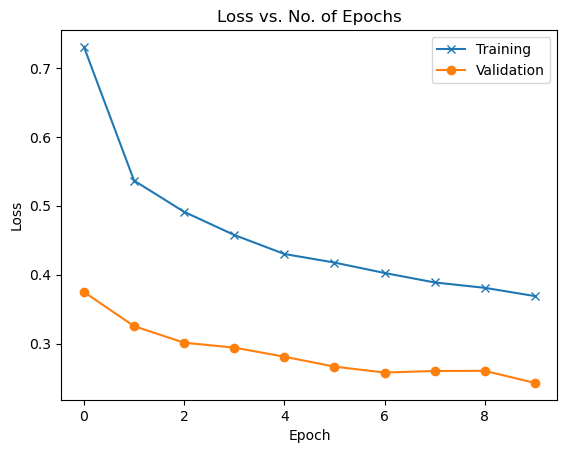

In [38]:
plot_losses(train_losses, val_losses)

## Train a model on the entire dataset

In [39]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)
dl = DeviceDataLoader(dl, device)

**Set the maximum number of training epochs and the learning rate for finetuning your model.**

In [40]:
# For final training on the full dataset
num_epochs = 15  # Increased from 10 to 15 for better convergence
lr = 0.001  # Maintain the same learning rate as it was effective in previous training


In [41]:
history = train_model(num_epochs, model, dl, [], loss_fn, opt_fn, lr)
model = history[0]

Epoch: 1/15, Batch: 0/938, Loss: 0.3149
Epoch: 1/15, Batch: 100/938, Loss: 0.2238
Epoch: 1/15, Batch: 200/938, Loss: 0.2612
Epoch: 1/15, Batch: 300/938, Loss: 0.5824
Epoch: 1/15, Batch: 400/938, Loss: 0.4169
Epoch: 1/15, Batch: 500/938, Loss: 0.3996
Epoch: 1/15, Batch: 600/938, Loss: 0.3777
Epoch: 1/15, Batch: 700/938, Loss: 0.3292
Epoch: 1/15, Batch: 800/938, Loss: 0.2829
Epoch: 1/15, Batch: 900/938, Loss: 0.5688
Epoch 1/15, Train Loss: 0.3745, Train Acc: 0.8569
Epoch: 2/15, Batch: 0/938, Loss: 0.2678
Epoch: 2/15, Batch: 100/938, Loss: 0.3784
Epoch: 2/15, Batch: 200/938, Loss: 0.2788
Epoch: 2/15, Batch: 300/938, Loss: 0.4844
Epoch: 2/15, Batch: 400/938, Loss: 0.4752
Epoch: 2/15, Batch: 500/938, Loss: 0.5075
Epoch: 2/15, Batch: 600/938, Loss: 0.4028
Epoch: 2/15, Batch: 700/938, Loss: 0.3500
Epoch: 2/15, Batch: 800/938, Loss: 0.4372
Epoch: 2/15, Batch: 900/938, Loss: 0.4547
Epoch 2/15, Train Loss: 0.3623, Train Acc: 0.8609
Epoch: 3/15, Batch: 0/938, Loss: 0.3187
Epoch: 3/15, Batch: 100/

## Check Predictions

In [42]:
def view_prediction(img, label, probs, classes):
    """
    Visualize predictions.
    """
    probs = probs.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(8,15), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).cpu().numpy().squeeze(), cmap='Greys_r')
    ax1.axis('off')
    ax1.set_title('Actual: {}'.format(classes[label]))
    ax2.barh(np.arange(10), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes, size='small');
    ax2.set_title('Predicted: probabilities')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

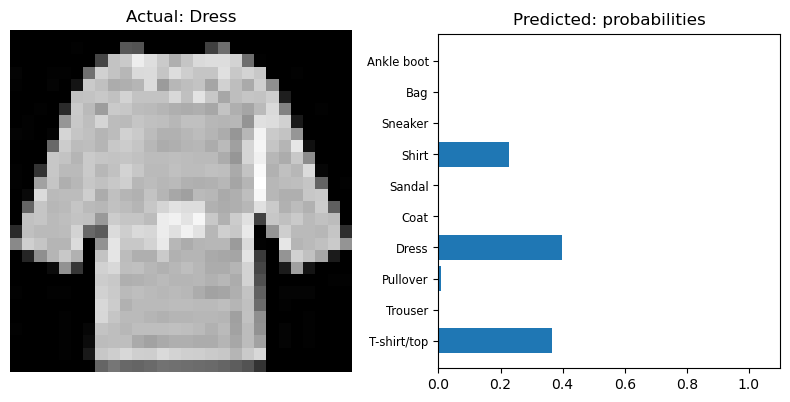

In [43]:
# Calculate the class probabilites (log softmax) for img
images = iter(dl)
for imgs, labels in images:
    with torch.no_grad():
        model.eval()
        # Calculate the class probabilites (log softmax) for img
        probs = torch.nn.functional.softmax(model(imgs[0].unsqueeze(0)), dim=1)
        # Plot the image and probabilites
        view_prediction(imgs[0], labels[0], probs, dataset.classes)
    break

## Save the model

In [44]:
# Very important
torch.save(model, 'model')

## Question 4 (10 points)

## Compute accuracy on the test set

In [45]:
test_dataset = FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

In [46]:
test_dl = DataLoader(test_dataset, batch_size)
test_dl = DeviceDataLoader(test_dl, device)

In [47]:
def evaluate(model, test_dl):
    """
    Evaluates your model on the test data.
    
    Args:
        model: ImageClassifierNet object
        test_dl: test dataloader
    
    Returns: 
        Test accuracy.
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_dl:
            # Forward pass
            outputs = model(images)
            
            # Get predictions
            _, predicted = outputs.max(1)
            
            # Count correct predictions
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    # Calculate and return accuracy
    accuracy = correct / total
    return accuracy

In [48]:
print("Test Accuracy = {:.4f}".format(evaluate(model, test_dl)))

Test Accuracy = 0.9118


## Tips to increase the test accuracy

- **Data augmentation:** Diversifies your training set and leads to better generalization
    - Flipping
    - Rotation
    - Shifting
    - Cropping
    - Adding noise
    - Blurring
    
- **Regularization:** Reduces overfitting on the training set
    - Early stopping
    - Dropout
    - $l_2$ regularization
    - Batch normalization

- **Hyperparameter tuning:**
    - Weight initialization
    - Learning rate
    - Activation functions
    - Optimizers